=== MINI V-JEPA: Ball Bouncing Video ===
Video shape: torch.Size([16, 1, 32, 32])


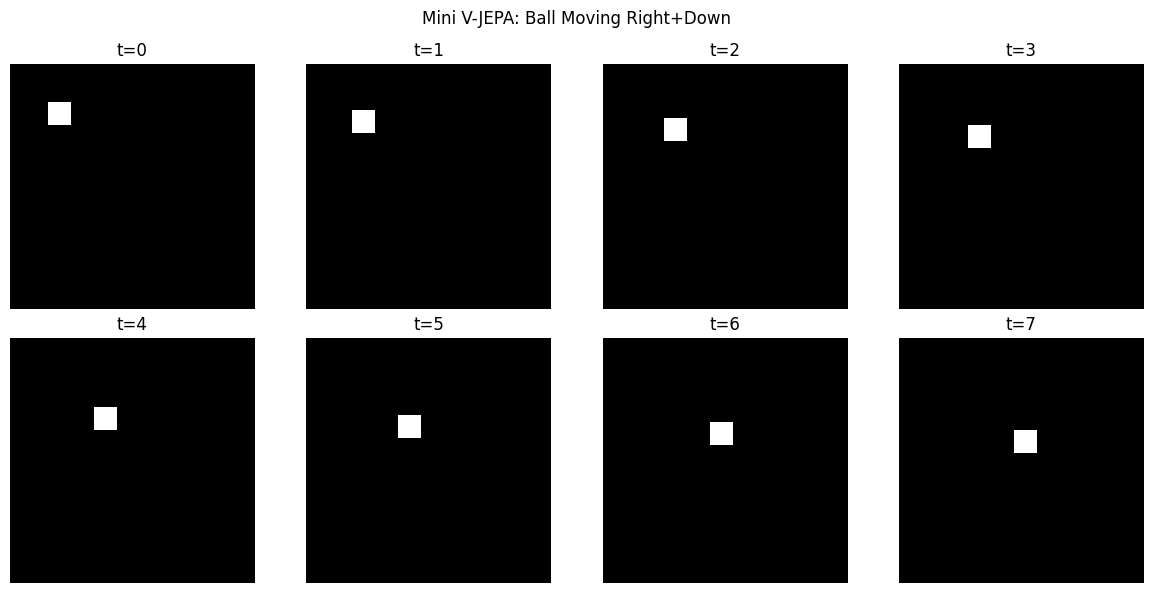

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

print("=== MINI V-JEPA: Ball Bouncing Video ===")

# ★ SYNTHETIC VIDEO: 16 frames of ball bouncing (grayscale 32x32)
def generate_ball_video(T=16, size=32):
    """Ball moves diagonally across screen"""
    video = np.zeros((T, 1, size, size))
    for t in range(T):
        x = int(5 + t * 1.5)  # Rightward
        y = int(5 + t * 1.0)  # Downward
        if x < size-3 and y < size-3:
            video[t, 0, y:y+3, x:x+3] = 1.0  # Ball position
    return torch.tensor(video, dtype=torch.float32)

video = generate_ball_video()
print(f"Video shape: {video.shape}")  # [16, 1, 32, 32]

# Visualize first 8 frames
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    axs[i//4, i%4].imshow(video[i,0], cmap='gray')
    axs[i//4, i%4].set_title(f"t={i}")
    axs[i//4, i%4].axis('off')
plt.suptitle("Mini V-JEPA: Ball Moving Right+Down")
plt.tight_layout()
plt.show()

In [29]:
# ★ MINI V-JEPA ARCHITECTURE
class MiniVJEPA(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.D = latent_dim

        # ★ 3D Conv (simplified)
        self.space_time_conv = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3,4,4), stride=(1,2,2), padding=(1,1,1)),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3,3,3), stride=(1,1,1), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((2, 4, 4))  # [B,64,T=2,H=4,W=4]
        )

        # ★ Space-Time Transformer (simple MLP patches)
        self.context_transformer = nn.Linear(64*2*4*4, latent_dim)  # Flatten → z_t
        self.target_transformer  = nn.Linear(64*2*4*4, latent_dim)

        # ★ Predictor: 6-layer transformer decoder (simplified MLP)
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim),    # z_pred
        )

        # ★ Decoder
        # ★ FAIL-SAFE DECODER: Pure MLP
        # 64 latent -> 4 frames * 32 * 32 pixels = 4096 output values
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4 * 32 * 32), # Output all pixels at once
            nn.Sigmoid()
        )
        # We don't need decoder_conv anymore



    def encode_video(self, video_chunk):
        """3D Conv + flatten → latent"""
        #conv_out = self.space_time_conv(video_chunk)  # [B,64,T=2,H=4,W=4]
        # permute(0, 2, 1, 3, 4) swaps dimension 1 (Time) and 2 (Channel)
        video_chunk = video_chunk.permute(0, 2, 1, 3, 4)

        conv_out = self.space_time_conv(video_chunk)

        flat = conv_out.flatten(start_dim=1)        # Global time avg → [B,64*4*4]
        return flat

    def forward(self, video):
        B, T, C, H, W = video.shape

        # ★ MASKING: Hide frames t=8,9,10,11 (future)
        context_frames = video[:, :8]    # [B,8,C,H,W] past+present
        target_frames  = video[:, 8:12]  # [B,4,C,H,W] future (masked)

        # ★ ENCODE
        z_context = self.context_transformer(self.encode_video(context_frames))
        z_target  = self.target_transformer(self.encode_video(target_frames))

        # ★ PREDICT
        z_pred = self.predictor(z_context)
        return F.mse_loss(z_pred, z_target), z_context, z_target, z_pred

    def decode(self, z):
        """Simple decode: MLP -> Reshape"""
        # z is [B, 64]
        pixels_flat = self.decoder_fc(z) # [B, 4096]

        # Reshape to [B, Time=4, C=1, H=32, W=32]
        pixels = pixels_flat.view(-1, 4, 1, 32, 32)
        return pixels

In [47]:
def get_random_batch(batch_size=1, T=16, size=32):
    """
    Generates a batch of videos with random ball trajectories.
    Output: [B, T, 1, H, W]
    """
    batch_videos = []

    for b in range(batch_size):
        video = np.zeros((T, 1, size, size), dtype=np.float32)

        # Start near center-left so it has space to move right
        start_x = np.random.randint(2, 8)
        start_y = np.random.randint(2, 25) # More vertical freedom

        # Only move RIGHT (positive X) to simplify the task first
        speed_x = 0.5 + np.random.rand() * 1.0 # Always move right
        speed_y = (np.random.rand() - 0.5) * 1.0 # Move up OR down slightly

        # 3. Generate Frames
        for t in range(T):
            # Calculate current pos
            x = int(start_x + t * speed_x)
            y = int(start_y + t * speed_y)

            # Draw 3x3 ball if inside screen
            if x < size-3 and y < size-3:
                video[t, 0, y:y+3, x:x+3] = 1.0

        batch_videos.append(video)

    # Stack into tensor
    return torch.tensor(np.stack(batch_videos))

In [48]:
# ★ TRAIN
print("\n🚀 Training Mini V-JEPA...")
model = MiniVJEPA(latent_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1500):
    video_batch = get_random_batch(batch_size=8) # Train on 8 videos at once

    loss_jepa, z_c, z_t, z_p = model(video_batch)

    pred_pixels = model.decode(z_t)
    target_pixels = video_batch[:, 8:12] # The actual target frames
    loss_decoder = F.mse_loss(pred_pixels, target_pixels)

    total_loss = loss_jepa + loss_decoder # Train both!

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # ★ EMA UPDATE (teacher forcing)
    with torch.no_grad():
        ema_alpha = 0.995
        for pt, pc in zip(model.target_transformer.parameters(),
                         model.context_transformer.parameters()):
            pt.data = ema_alpha * pt.data + (1-ema_alpha) * pc.data

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.item():.4f} | "
              f"z_c[0:3]={z_c[0,:3].detach().numpy()} → "
              f"z_pred[0:3]={z_p[0,:3].detach().numpy()}")

print("\n✓ Mini V-JEPA trained!")


🚀 Training Mini V-JEPA...
Epoch 0: Loss = 0.2529 | z_c[0:3]=[-0.015772   -0.02199029 -0.03555052] → z_pred[0:3]=[ 0.03030459 -0.01702312  0.06620776]
Epoch 100: Loss = 0.0088 | z_c[0:3]=[0.14026904 0.09300036 0.2112485 ] → z_pred[0:3]=[ 0.1267959  -0.13291427  0.10344127]
Epoch 200: Loss = 0.0088 | z_c[0:3]=[0.14176194 0.08807687 0.21529345] → z_pred[0:3]=[ 0.12173279 -0.06688732  0.11427089]
Epoch 300: Loss = 0.0087 | z_c[0:3]=[0.09159822 0.06177358 0.15546817] → z_pred[0:3]=[ 0.07940907 -0.0013579   0.09606656]
Epoch 400: Loss = 0.0084 | z_c[0:3]=[0.10224111 0.02493803 0.18404981] → z_pred[0:3]=[0.08905375 0.01638346 0.11152675]
Epoch 500: Loss = 0.0082 | z_c[0:3]=[0.06476799 0.041743   0.14697346] → z_pred[0:3]=[0.08479932 0.01422084 0.11580294]
Epoch 600: Loss = 0.0085 | z_c[0:3]=[0.05877344 0.04280147 0.14306778] → z_pred[0:3]=[0.07848494 0.01509708 0.11701182]
Epoch 700: Loss = 0.0087 | z_c[0:3]=[0.02392567 0.02984105 0.09748784] → z_pred[0:3]=[0.07030357 0.00873504 0.11412895]


In [49]:
# ★ TEST PREDICTION
print("\n=== VIDEO DYNAMICS TEST ===")
model.eval()
with torch.no_grad():
    loss, z_context, z_target, z_pred = model(video_batch)

    print(f"Context frames [t=0-7]: Ball at bottom-left → z_context[0:3] = {np.round(z_context[0,:3].numpy(), 3)}")
    print(f"Target frames  [t=8-11]: Ball mid-right    → z_target [0:3]  = {np.round(z_target [0,:3].numpy(), 3)}")
    print(f"PREDICTED:                            → z_pred   [0:3]  = {np.round(z_pred   [0,:3].numpy(), 3)}")
    print(f"Prediction Error: {total_loss.item():.4f}")

    # Test extrapolation
    print("\n🎯 ROLLOUT: Predict t=12-15 from t=0-7")
    z_t12_pred = model.predictor(z_pred)
    print(f"z_t0 → z_t12_pred[0:3] = {np.round(z_t12_pred[0,:3].numpy(), 3)}")


=== VIDEO DYNAMICS TEST ===
Context frames [t=0-7]: Ball at bottom-left → z_context[0:3] = [ 0.044 -0.023  0.059]
Target frames  [t=8-11]: Ball mid-right    → z_target [0:3]  = [-0.02   0.038  0.01 ]
PREDICTED:                            → z_pred   [0:3]  = [-0.019  0.043  0.011]
Prediction Error: 0.0084

🎯 ROLLOUT: Predict t=12-15 from t=0-7
z_t0 → z_t12_pred[0:3] = [-0.002  0.012  0.024]


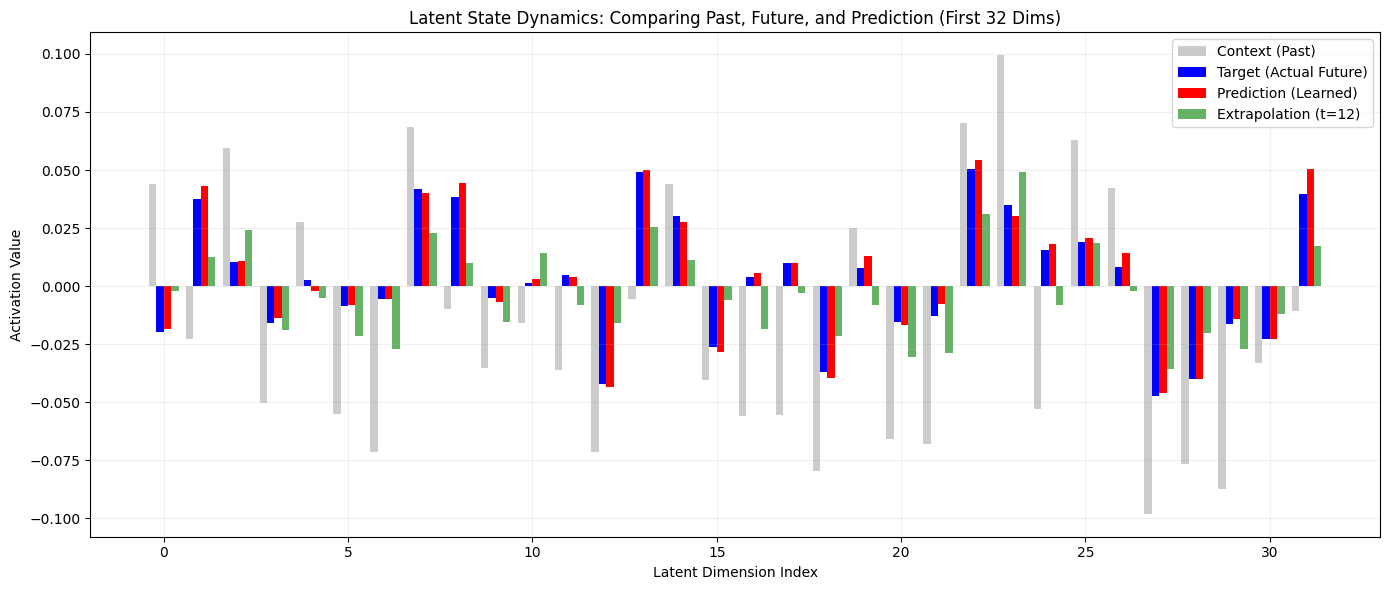

In [50]:
# ★ VISUALIZE PREDICTION
# Convert tensors to numpy (take first item in batch)
# We only plot the first 32 dimensions to keep it readable
D_show = 32
z_c = z_context[0, :D_show].detach().numpy()
z_t = z_target[0, :D_show].detach().numpy()
z_p = z_pred[0, :D_show].detach().numpy()
z_extra = z_t12_pred[0, :D_show].detach().numpy()

# Create a comparison plot
fig, ax = plt.subplots(figsize=(14, 6))
indices = np.arange(D_show)
width = 0.2

# Plot bars for each vector
ax.bar(indices - width*1.5, z_c, width, label='Context (Past)', color='gray', alpha=0.4)
ax.bar(indices - width/2,   z_t, width, label='Target (Actual Future)', color='blue')
ax.bar(indices + width/2,   z_p, width, label='Prediction (Learned)', color='red')
ax.bar(indices + width*1.5, z_extra, width, label='Extrapolation (t=12)', color='green', alpha=0.6)

ax.set_title(f'Latent State Dynamics: Comparing Past, Future, and Prediction (First {D_show} Dims)')
ax.set_xlabel('Latent Dimension Index')
ax.set_ylabel('Activation Value')
ax.legend()
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

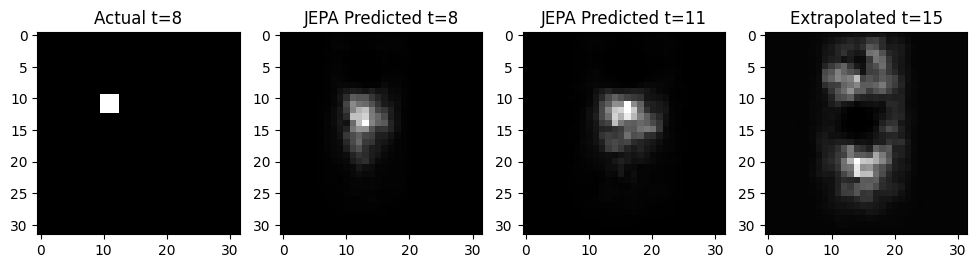

In [63]:
# After training...
model.eval()
with torch.no_grad():
    # 1. Decode the PREDICTED future (t=8..11)
    # This is what the model "imagined" based on the past
    imagined_video = model.decode(z_pred) # [1, 2, 1, 32, 32] (Note: our simple decoder outputs 2 frames for simplicity)

    # 2. Decode the EXTRAPOLATED future (t=12..)
    extrapolated_video = model.decode(z_t12_pred)

    # VISUALIZE
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # Show Ground Truth (Target)
    axs[0].imshow(video_batch[0][8, 0], cmap='gray')
    axs[0].set_title("Actual t=8")

    # Show What JEPA Predicted (Imagined)
    axs[1].imshow(imagined_video[0, 0, 0], cmap='gray')
    axs[1].set_title("JEPA Predicted t=8")

    # Show Actual t=11 (if available in gen function) or just next step
    axs[2].imshow(imagined_video[0, 3, 0], cmap='gray')
    axs[2].set_title("JEPA Predicted t=11")

    # Show Extrapolation
    axs[3].imshow(extrapolated_video[0, 2, 0], cmap='gray')
    axs[3].set_title("Extrapolated t=15")

    plt.show()

In [56]:
video_batch[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.